# Bike Sharing Demand

### Data Fields  
- datetime - hourly date + timestamp  <br>
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter <br>
- holiday - whether the day is considered a holiday<br>
- workingday - whether the day is neither a weekend nor holiday<br><br>
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
- temp - temperature in Celsius<br>
- atemp - "feels like" temperature in Celsius<br>
- humidity - relative humidity<br>
- windspeed - wind speed<br>
- casual - number of non-registered user rentals initiated<br>
- registered - number of registered user rentals initiated<br>
- count - number of total rentals<br>

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats

# 노트북 안 그래프 그리기
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 적용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [85]:
train = pd.read_csv('bike_train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [69]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [70]:
test = pd.read_csv('bike_test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

In [71]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## Feature Engineering

In [86]:
train['year'] = train['datetime'].dt.year 
train['month'] = train['datetime'].dt.month 
train['day'] = train['datetime'].dt.day 
train['hour'] = train['datetime'].dt.hour 
train['minute'] = train['datetime'].dt.minute 
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek

train.shape

(10886, 19)

In [73]:
test['year'] = test['datetime'].dt.year 
test['month'] = test['datetime'].dt.month 
test['day'] = test['datetime'].dt.day 
test['hour'] = test['datetime'].dt.hour 
test['minute'] = test['datetime'].dt.minute 
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek

test.shape

(6493, 16)

[Text(0.5, 1.0, 'Test windspped')]

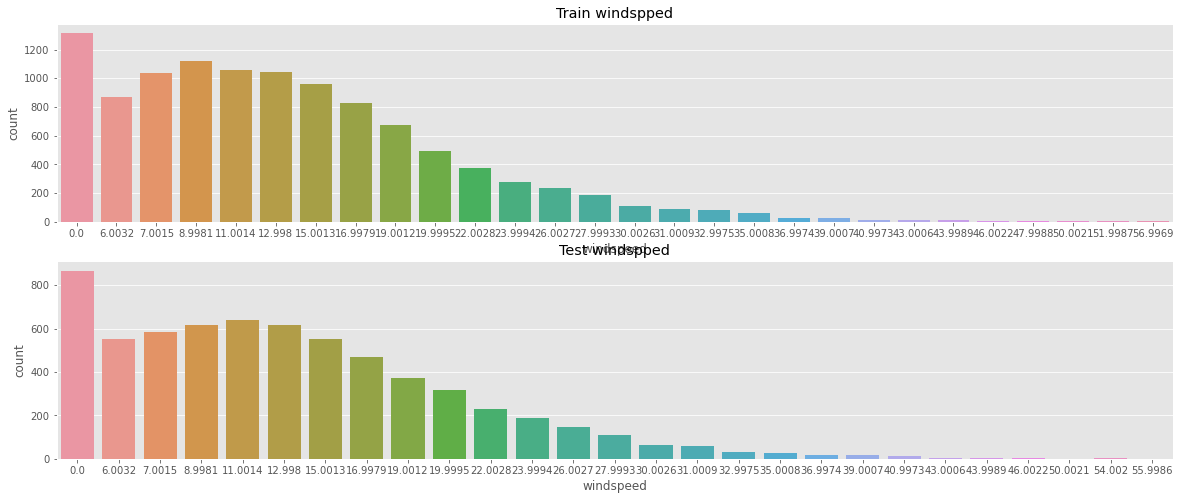

In [74]:
# 풍속 데이터 시각화
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(20, 8)

# train
plt.sca(axes[0])
sns.countplot(data=train, x='windspeed')
axes[0].set(title='Train windspped')

# test
plt.sca(axes[1])
sns.countplot(data=test, x='windspeed')
axes[1].set(title='Test windspped')

- test, train 데이터셋에 0 값이 가장 많다.
- -> 바로 다음 풍속이 6으로 시작하고 구간이 1-3 정도로 촘촘하기 때문에 0값이 많은 것은 측정하지 못한 데이터를 0으로 둔 것 같다.
- -> 풍속 0인 값에 특정 값을 넣는 feature engieeniering을 한다.

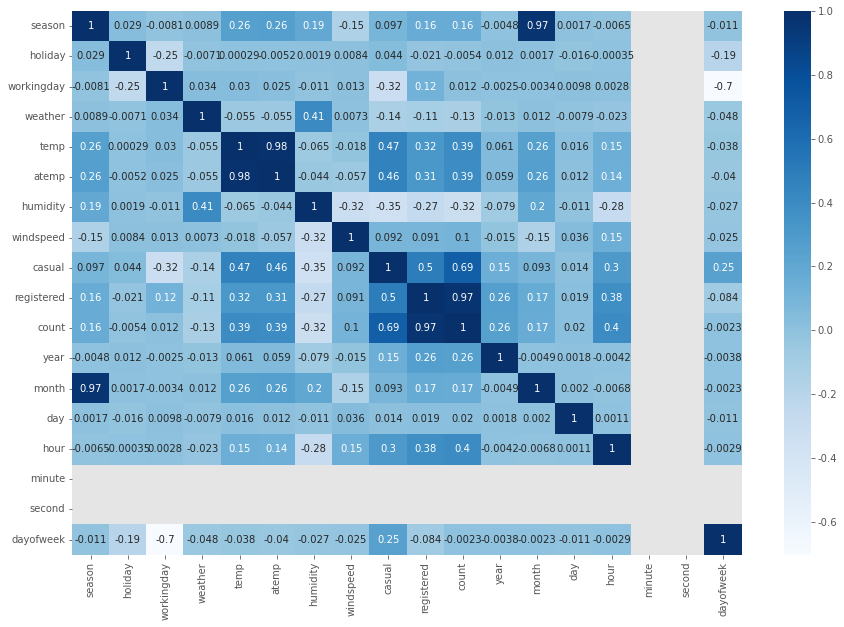

In [62]:
plt.figure(figsize=(15, 10))
sns.heatmap(train.corr(), annot=True, cmap='Blues')
plt.show()

In [75]:
# 풍속이 0인 것과 아닌 것의 세트를 나누어 준다.

train_w0 = train.loc[train['windspeed']==0,:]
train_wx = train.loc[train['windspeed']!=0,:]

print('풍속이 0인 세트 :', train_w0.shape)
print('풍속이 0이 아닌 세트 :', train_wx.shape)

풍속이 0인 세트 : (1313, 19)
풍속이 0이 아닌 세트 : (9573, 19)


In [91]:
# 머신러닝으로 예측을 해서 풍속을 넣어주기
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누기
    dataWind0 = data.loc[data['windspeed'] == 0] # test 
    dataWindNot0 = data.loc[data['windspeed'] != 0] # train
    
    # 풍속을 예측할 feature 선택
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # datawindX 데이터셋에서 풍속 string으로 데이터타입 바꾸기  => ??
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 모델링
    rfModel_wind = RandomForestClassifier()

    # 학습하기
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 예측하기
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # 데이터프레임 합치기
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

In [88]:
# 0 값을 조정
train = predict_windspeed(train)

<ipython-input-87-9ff135a9fb85>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
<ipython-input-87-9ff135a9fb85>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictWind0["windspeed"] = wind0Values


<AxesSubplot:xlabel='windspeed', ylabel='count'>

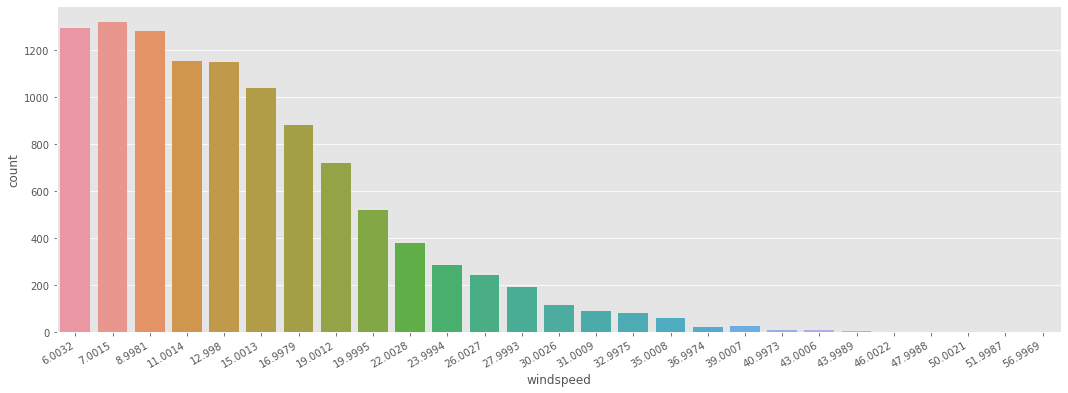

In [89]:
# windspeed 조정 결과 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
sns.countplot(data=train, x='windspeed', ax=ax1)

풍속이 0인 데이터들이 예측된 값으로 들어감

## Feature Selection

- 신호와 잡음 구분
- 피처가 많다고 무조건 좋은 성능을 내지 않음
- 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거

feature 나누기 (범주형 / 연속형)

In [94]:
# 범주형 feature
feature_category = ['season', 'holiday', 'workingday', 'weather',
                'dayofweek', 'month', 'year', 'hour']

# 데이터타입 변환
for var in feature_category:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [96]:
# feature 선택
feature = ['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
           'year', 'hour', 'dayofweek', 'holiday', 'workingday']
feature

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

- x, y 나누기

In [103]:
# x_train
x_train = train[feature]
x_train.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [98]:
# x_test
x_test = test[feature]
x_test.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [102]:
# y_train
target = 'count'

y_train = train[target]
y_train.head()

0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

## Score

- 해당 캐글 대회에서는 RMSLE를 기준으로 평가

#### RMSLE
- 과소평가된 항목에 패널티 부과
- 0에 가까운 값이 나올수록 정밀도가 높은 편

In [104]:
from sklearn.metrics import make_scorer

def rmsle(predicted_value, actual_value):
    
    # 배열로 변환 
    predicted_value = np.array(predicted_value)
    actual_value = np.array(actual_value)
    
    # 예측값과 실제 값에 1을 더하고 로그변환
    log_predict = np.log(predicted_value + 1)
    log_actual = np.log(actual_value + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균
    mean_difference = difference.mean()
    
    # 루트변환
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

#### K_Flod

In [106]:
# conda install -c conda-forge KFold

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.

Note: you may need to restart the kernel to use updated packages.



PackagesNotFoundError: The following packages are not available from current channels:

  - kfold

Current channels:

  - https://conda.anaconda.org/conda-forge/win-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [110]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## Modeling

In [109]:
# 불러오기
from sklearn.ensemble import RandomForestRegressor

# 모델링
model = RandomForestRegressor(random_state=0)

# 학습하기
model.fit(x_train, y_train)

# 예측하기
y_pred = model.predict(x_test)

In [115]:
# 평가하기

%time score = cross_val_score(model, x_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
print('Score : {0:.5f}'.format(score))

Wall time: 25.2 s
Score : 0.33109


C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


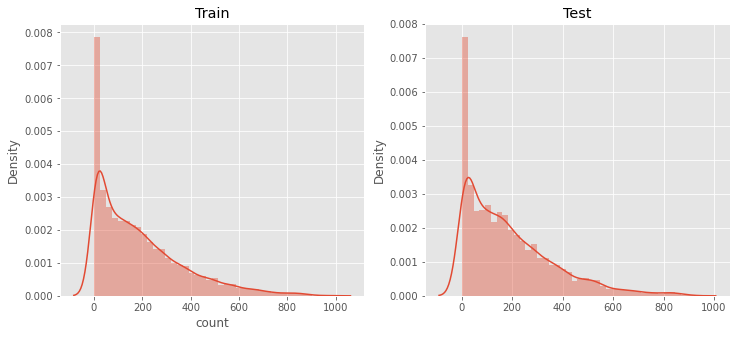

In [118]:
# 예측한 데이터 시각화
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_train, ax=ax1, bins=40)
ax1.set(title='Train')
sns.distplot(y_pred, ax=ax2, bins=40)
ax2.set(title='Test')
plt.show()

## Submit 

In [119]:
submission = pd.read_csv("bike_sampleSubmission.csv")
submission

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [120]:
# 예측한 값 넣기
submission["count"] = y_pred

# 확인
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.44
1,2011-01-20 01:00:00,5.01
2,2011-01-20 02:00:00,4.17
3,2011-01-20 03:00:00,3.58
4,2011-01-20 04:00:00,3.11


In [121]:
# 예측한 값 넣고 새로운 파일 만들기
submission.to_csv('bike_score_{0:.5f}_submission.csv'.format(score), index=False)